In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

multi-armed (or k-armed) bandits are a set of problems from proability and statistics in which a finite set of resources must be allocated among multiple options in order to maximise the expected return with little or no explicit prior knowledge of utility of the available options. 

For example, a gambler in a casino has the choice between five different slot machines, each costs a dollar to play and returns some random dollar amount based on a fixed probability distribution, where the reward distribution of each machine is independent of the others. He starts with \$10 and wants to find which machine out of the five gives him the highest return. He may start by trying all five slot machines once to find which one returns the most, however as the reward is random, 1 trial will likely not provide enough information as which which, in the long run, provides the highest yield. If he were to play each machine 100 times, one by one, he will likly run out of money (or get thrown out at closing time) before making his choice of machine. He instead must come up with a strategy to find the best machine in as few steps as possible.

The multi-armed bandit problem is a popular framework for reinforcement learning. It represents a scenario in which some agent must self-evaluate its actions in order to learn the best course of action for the given situation. However, it represents a very limited set of the overall reinforcement learning landscape. In particular, it differs from full reinforcement learning as the reward is recieved immediately after a single action is taken.

There are countless variations and expansions on the bandit problem. This introduction this focuses on a class of bandits in which rewards are iid and stationary and the goal of the agent is to maximuse a numerical reward over a finite, but relatively large, amount of steps (if the agent were allowed to run indefinitely its actons would be irrelevant because with infinite amount of time any action giving a positive reward will lead to infinite reward). More advanced approaches consider non-stationary rewards or situations in which the number of possible trials is severely limited.

k-armed bandits exemplify the exploration/exploitation tradeoff in which the agent must balance exploitation of existing knowledge to maximise reward vs exploration of the system to improve exsting knlowedge and update its strategy accordingly.
"the dilemma for a decision-making system that only has incomplete knowledge of the world is whether to repeat decisions that have worked well so far (exploit) or to make novel decisions, hoping to gain even greater rewards (explore)."

#### The problem:
An agent is faced with a choice of k different options, be it which slot machine to play at the casino, which ad to display on a website or which dosage of a drug to prescribe in a clinical trial. After each choice, the outcome can be translated to some numerical reward. The goal is to maximize the total reward over some set time period.

Initially, the estimated rewards for each action are set to 0. Since the rewards are stochastic, it is a bad idea to, foor example, use only the latest reward value as the estimated reward. Instead the values are estimated as sample averages of observed rewards. The simplest approach to would be to keep track of all rewards revieved and calcuate the mean value at each time step. The main drawback of this approach is that the time complexity and memory requirements scale linearly with each time step. This is not a issue for these toy problems but can become a major hindrance for reinforcement learning problems with many possible actions take over a long period of time. 

Instead each action value is updated according to:
$$NewEstimate = OldEstimate + \frac{1}{n}[reward - OldEstimate]$$
where n is the current time step and reward is the numerical reward recieved.

### ε-greedy
the  ε-greedy (epsilon-greedy) approach is a naive approach to the exploraion exploitation problem. it simply states that for any  ε [0,1], choose an action greedily wit probability 1-ε otherwise choose randomly from the other options. For example, for ε=0.2, the agent would choose greedily 80% of the time and randomly from the other options 20% of the time. Chosing the correct value for ε is important and can vary depending on the given task. Choosing an ε that is too high can lead to actions being wasted needlessly exploring sub-optimal actions, whereas an ε that is too low can lead to slow convergence.

In [2]:
arms = 10
n_steps = 1000
n_trials = 100

class Bandit():
    def __init__(self, arms):
        self.arms = arms
        self.rewards_mu = np.random.normal(0, 1, arms)
        self.optimal = np.argmax(self.rewards_mu)
    def play(self, arm):
        m = self.rewards_mu[arm]
        return np.random.normal(m, 0.5)

In [3]:
def plot_results(results, ax, label=None):
    ax[0].set_title("Average reward")
    ax[1].set_title("% optimal action")
    rewards = results[:, 0, :]
    average_step_reward = np.cumsum(rewards, axis=1) / (np.arange(n_steps)+1)
    average_trial_reward = average_step_reward.mean(axis=0)
    sns.lineplot(np.arange(n_steps), average_trial_reward, label=label, ax=ax[0])
    optimal_action = results[:, 1, :]
    average_trial_optimal = optimal_action.mean(axis=0)
    sns.lineplot(np.arange(n_steps), average_trial_optimal, label=label, ax=ax[1])

In [4]:
def exploit(values):
    return np.argmax(values)

def explore(values):
    p = np.ones_like(values) / (len(values)-1)
    p[exploit(values)] = 0
    # this implementation means that when exploring,
    # the greedy option will not be chosen
    # this means that e=1 will never choose the optimal action
    
    ind = list(range(len(values)))
    return np.random.choice(ind, p=p)

In [5]:


def epsilon_greedy(bandit, steps, epsilon):

    action_values = np.zeros(bandit.arms)

    actions_taken = np.zeros_like(action_values)

    rewards = []
    optimal = []
    p_optimal = []

    for i in range(n_steps):
        p = np.random.uniform()
        if p <= epsilon or sum(actions_taken) == 0:
            arm = explore(action_values)
        else:
            arm = exploit(action_values)
        
        reward = bandit.play(arm)

        actions_taken[arm] = actions_taken[arm] + 1
        action_values[arm] = action_values[arm] + (1 / actions_taken[arm]) * (reward - action_values[arm])
                
        rewards.append(reward)
        optimal.append(arm == bandit.optimal)
        p_optimal.append(np.mean(optimal[-(100 if len(optimal) > 99 else len(optimal)):]))
        
    return rewards, p_optimal

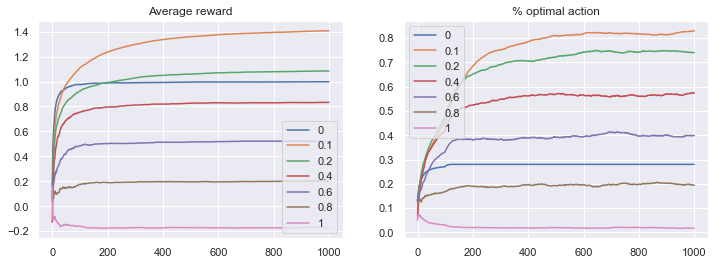

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

for epsilon in [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1]:
    results = np.array([epsilon_greedy(Bandit(arms), n_steps, epsilon=epsilon) for trial in range(n_trials)])
    plot_results(results, ax, epsilon)

As shown, the pure greedy (e=0), chooses the optimal action less frequently than most others, highlighting the importance of exploration, whereas e=0.1, recieves the largest overall reward, highlingting the need to exploit knowledge.

Since rewards are drawn from normal distributions with mean 0 and std 1 and action-values are initialised to 0, in the event that the optimal action actually returns a negative reward, the fully greedy (e = 1) will end up trying all arms over the first k trials.

Setting the initial values to some non-zero value can influence the behaviour of the learning. Setting the initial values to large positive values can encourage exploration early. By choosing large initial values, possibly larger than the true reward, a greedy algorithm will choose from less explored options more frequently in the inital stages of learning until all action values <i>decrease</i> towards there true value. It reduces the time spent on needless exploration in the later stages compared to the random exploration of ε-greedy without enforcing complex exploration heuristics. It follows the principle of "optimism in the face of uncertainty"

In [7]:
def epsilon_greedy_optimistic(bandit, steps, epsilon, initial_value=5):

    action_values = np.zeros(bandit.arms) + initial_value

    actions_taken = np.zeros_like(action_values)

    rewards = []
    optimal = []
    p_optimal = []

    for i in range(n_steps):
        p = np.random.uniform()
        if p <= epsilon or sum(actions_taken) == 0:
            arm = explore(action_values)
        else:
            arm = exploit(action_values)
        
        reward = bandit.play(arm)

        actions_taken[arm] = actions_taken[arm] + 1
        action_values[arm] = action_values[arm] + (1 / actions_taken[arm]) * (reward - action_values[arm])
                
        rewards.append(reward)
        optimal.append(arm == bandit.optimal)
        p_optimal.append(np.mean(optimal[-(100 if len(optimal) > 99 else len(optimal)):]))
        
    return rewards, p_optimal

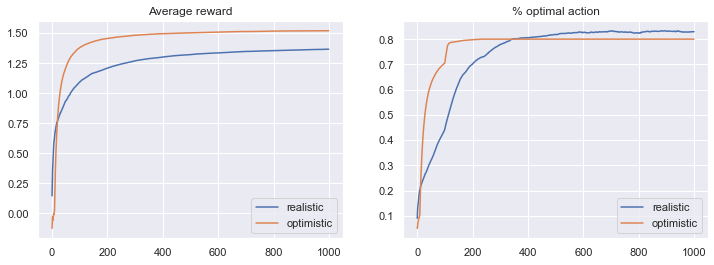

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

results = np.array([epsilon_greedy(Bandit(arms), 100, epsilon=0.1) for trial in range(100)])
plot_results(results, ax, 'realistic')

results = np.array([epsilon_greedy_optimistic(Bandit(arms), 100, epsilon=0) for trial in range(100)])
plot_results(results, ax, 'optimistic')

Optimistic initial values can encourage exploration even when a pure greedy action selection algorithm is used. It will often perform worse than e-greedy at first because it will explore more in the early stages, but will perform better in later stages (assuming stationary rewards). It works best when rewards don't change as exploration is carried out in early stages.

"it loses some efficiency by indiscriminately exploring"




## UCB

Due to the stochasticity of rewards, there is always a degree of uncertainty to which action is optimal. Actions that appear good early on actually turn out to be poor choices in the long run. e-greedy actin selection forces exploration but this exploration is independent of all previous observations, ie it samples randomly and uniformly from all non greedy options.
A more efficient approach would be to sample based existing knowledge, favouring exploration of actions based on their potential to return high rewards.

The Upper-Confidence-Bound algorithm for action selection 



"The algorithm is based on the principle of optimism in the face of uncertainty, which is to choose your actions as if the environment (in this case bandit) is as nice as is plausibly possible." In other words, actions are chosen based on which has the best potential for being optimal. Selection is made based on the upper bound of of what an action reasonably <i>could</i> yield given the uncertainty around the true value. 

The UCB approach to action selection and can be formulated with the simple heuristic:

$$A_t = \underset{a}{\operatorname{argmax}}\bigg[Q_t(a)+c\sqrt{\frac{ln(t)}{N_t(a)}}\bigg]$$

t = time step, Nt(a) = number of times action has been chosen prior to time t and c is a tunable constant which determines the rate of exploration.

$\sqrt{\frac{ln(t)}{N_t(a)}}$
is the heuristic measuring uncertainty for each action $a$. intuitively, the more times we repeat an action, the more sure of its true value we will become, increasing the value of the denominator. The ln(t) term on the other hand encourages exploration.

One important edge case is when the denominator ($N_t(A)$) is equal to 0, in which case, a is considered to be a maximising action. As a result, over the first k trials (k being the number of possible actions), the UCB algorithm will select each action exactly once.

In [9]:
def UCB(bandit, steps, c):

    action_values = np.zeros(bandit.arms)
    actions_taken = np.zeros_like(action_values)
    
    rewards = []
    optimal = []
    p_optimal = []
    
    for i in range(steps):
        ucb = np.zeros_like(action_values)
        for j in range(len(ucb)):
            if actions_taken[j] == 0:
                ucb[j] = np.iinfo(np.int32).max
                break
            
            ucb[j] = action_values[j] + c * (np.sqrt(np.log(i) / actions_taken[j]))
        
        arm = np.argmax(ucb) 
        
        reward = bandit.play(arm)

        actions_taken[arm] = actions_taken[arm] + 1
        action_values[arm] = action_values[arm] + (1 / actions_taken[arm]) * (reward - action_values[arm])
                
        rewards.append(reward)
        optimal.append(arm == bandit.optimal)
        p_optimal.append(np.mean(optimal[-(100 if len(optimal) > 99 else len(optimal)):]))
        
    return rewards, p_optimal

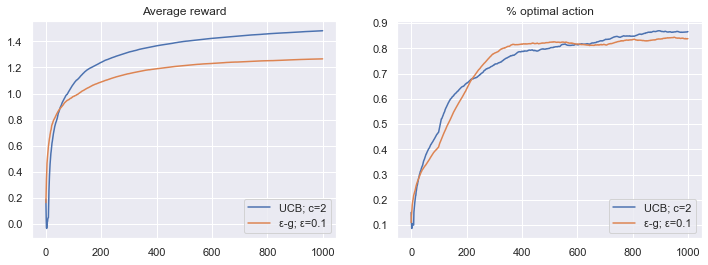

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

results = np.array([UCB(Bandit(arms), n_steps, c=2) for trial in range(n_trials)])
plot_results(results, ax, 'UCB; c=2')

results = np.array([epsilon_greedy(Bandit(arms), n_steps, epsilon=0.1) for trial in range(n_trials)])
plot_results(results, ax, 'ε-g; ε=0.1')

## Gradient bandits

The previous methods select actions based on estimated "action values" calculated for each possible action, representing the estimated reward for a give action. Gradient bandits instead choose actions based on a probability distribution and and dertermine the optimal action through stocastic gradient ascent.

A <i>preference</i> ($H$) is learned for each action and at each step the action will be chosen by sampling from the distribution of preferences across all actions. The action preferences are updated by the rules:

$$H_{t+1} = H_t(A_t)+\alpha(R_t-\bar{R}_t)(1-\pi_t(A_t))$$
and
$$H_{t+1}(a) = H_t(a)-\alpha(R_t-\bar{R}_t)\pi_t(a), a\neq A_t$$
    where $\pi_t(a)$ is the for the probability of taking action a at time $t$, $\alpha$ is the step size.

The probablity distribution is determined by the softmax function
$$\frac{e^{H_t(a)}}{\sum_{b=1}^ke^{H_t(b)}}$$

During each step, if the reward for the chosen action is higher than the average of all the previous rewards up to time t, then the preference for that action, or the probability of repeating that action in the future, is increased proportional to $R_t - \bar{R}_t$, if the reward is lower, the the preference decreases accordingly.

In [11]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def gradient_bandit(bandit, steps, alpha):
    
    preferences = np.zeros(bandit.arms)
    R = 0
    rewards = []
    optimal = []
    p_optimal = []

    for s in range(steps):
        probs = softmax(preferences)
        arm = np.random.choice(np.arange(10), p=probs)
        reward = bandit.play(arm)

        p = preferences[arm] + alpha*(reward - R)*(1-probs[arm])
        preferences = preferences - alpha*(reward - R) * probs
        preferences[arm] = p
        R = reward + (1/(s+1)) * (R - reward)
        rewards.append(reward)
        
        optimal.append(arm == bandit.optimal)
        p_optimal.append(np.mean(optimal[-(100 if len(optimal) > 99 else len(optimal)):]))
        
    return rewards, p_optimal

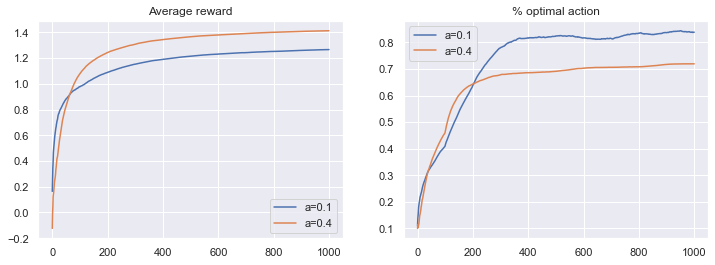

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

resuts = np.array([gradient_bandit(Bandit(arms), n_steps, alpha=0.1) for trial in range(n_trials)])
plot_results(results, ax, 'a=0.1')

results = np.array([gradient_bandit(Bandit(arms), n_steps, alpha=0.4) for trial in range(n_trials)])
plot_results(results, ax, 'a=0.4')